## Monitoring Results
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu
from smart_open import open
import pickle as pkl

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load config and set local variables with config["mconfig"]
with open("../../config.json", "r") as f:
    config = json.load(f)
    
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [3]:
# artifacts path
os.makedirs(artifact_path, exist_ok=True)

test_dfs = OrderedDict()

In [4]:
# read data
df = pd.read_parquet(test_df_path)

In [5]:
models = {}
for mname, mpath in model_paths.items():
    with open(mpath, "rb") as f:
        models[mname] = pkl.load(f)

### Active Accounts

  0%|          | 0/6 [00:00<?, ?it/s]

2021-01-01 (108168, 98)
data imbalance:  44.827186075424784
2021-01-01 (108168, 98)
data imbalance:  44.827186075424784


 17%|█▋        | 1/6 [00:12<01:02, 12.57s/it]

2021-02-01 (113775, 98)
data imbalance:  53.36538461538462
2021-02-01 (113775, 98)
data imbalance:  53.36538461538462


 33%|███▎      | 2/6 [00:26<00:52, 13.08s/it]

2021-03-01 (121831, 98)
data imbalance:  60.52210630899156
2021-03-01 (121831, 98)
data imbalance:  60.52210630899156


 50%|█████     | 3/6 [00:40<00:41, 13.70s/it]

2021-04-01 (120169, 98)
data imbalance:  59.69647292598112
2021-04-01 (120169, 98)
data imbalance:  59.69647292598112


 67%|██████▋   | 4/6 [00:54<00:28, 14.02s/it]

2021-05-01 (124748, 98)
data imbalance:  66.46137453383058
2021-05-01 (124748, 98)
data imbalance:  66.46137453383058


 83%|████████▎ | 5/6 [01:09<00:14, 14.38s/it]

2021-06-01 (127730, 98)
data imbalance:  101.77689243027888
2021-06-01 (127730, 98)
data imbalance:  101.77689243027888


100%|██████████| 6/6 [01:25<00:00, 14.21s/it]


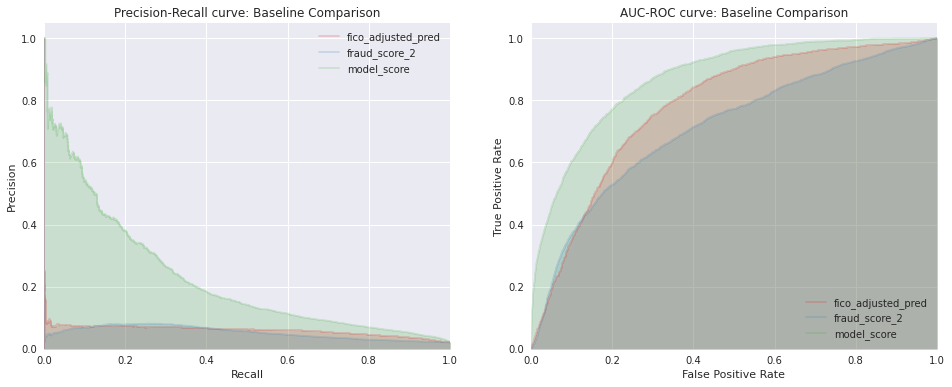

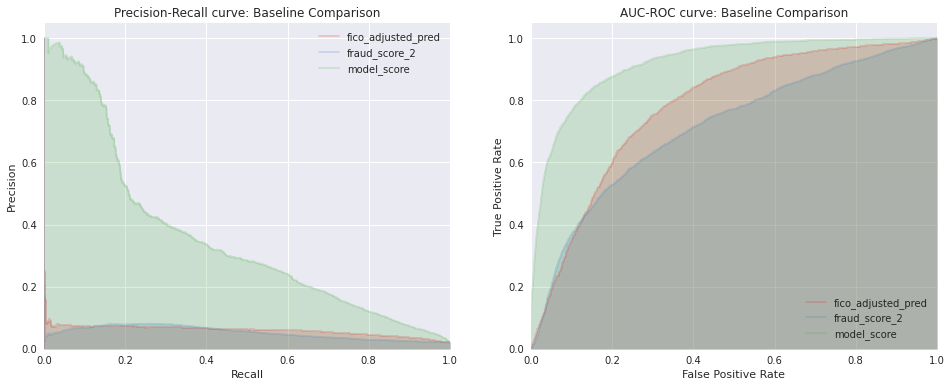

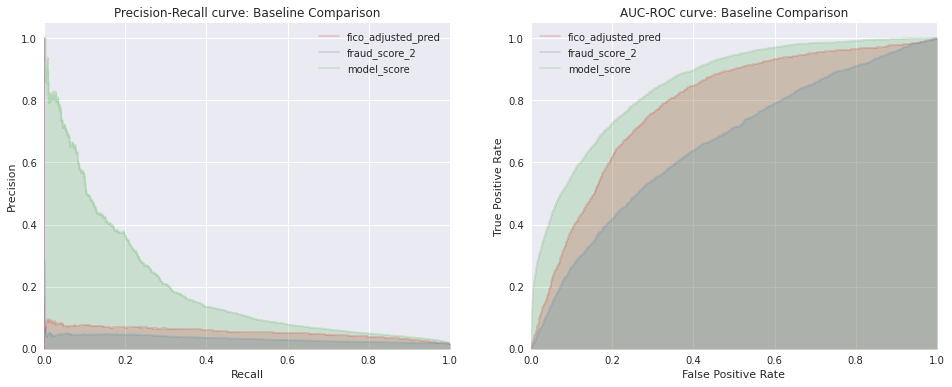

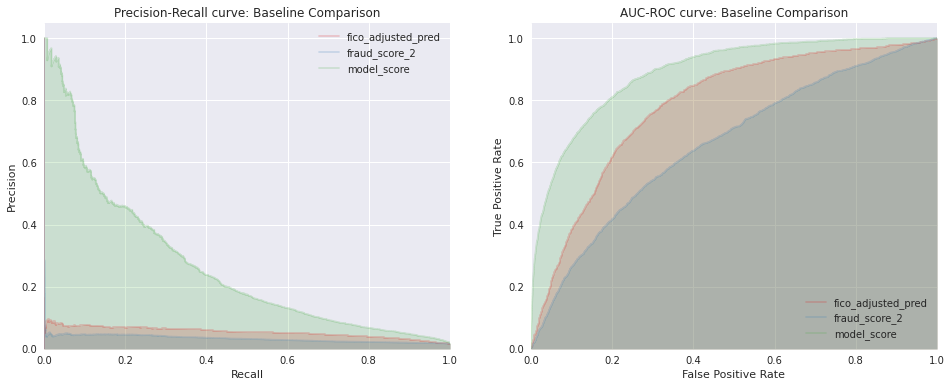

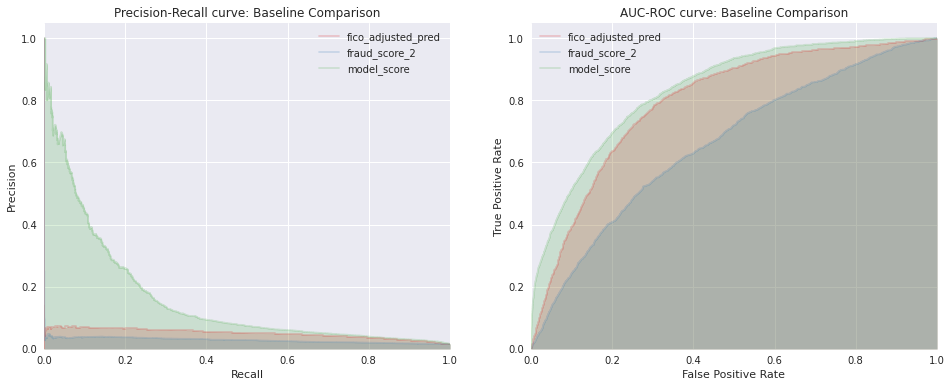

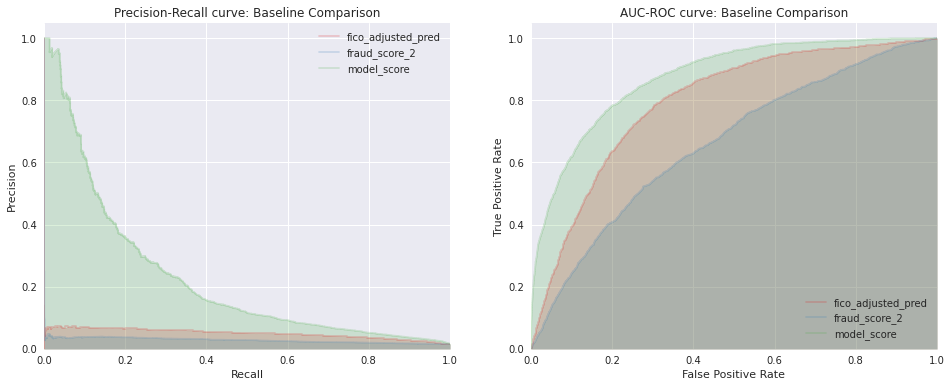

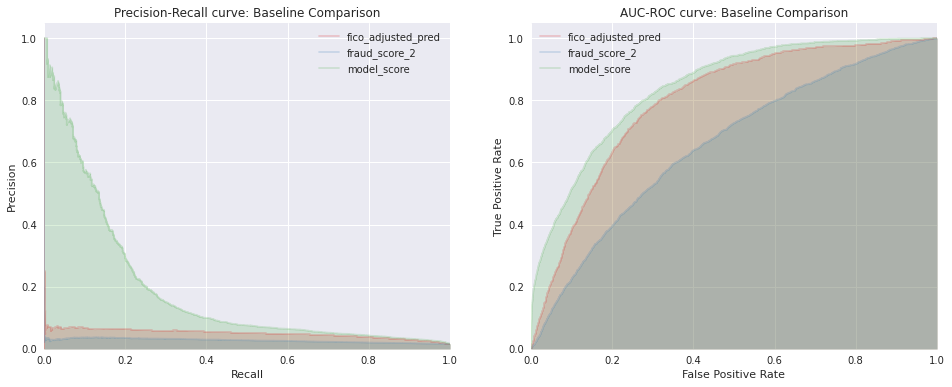

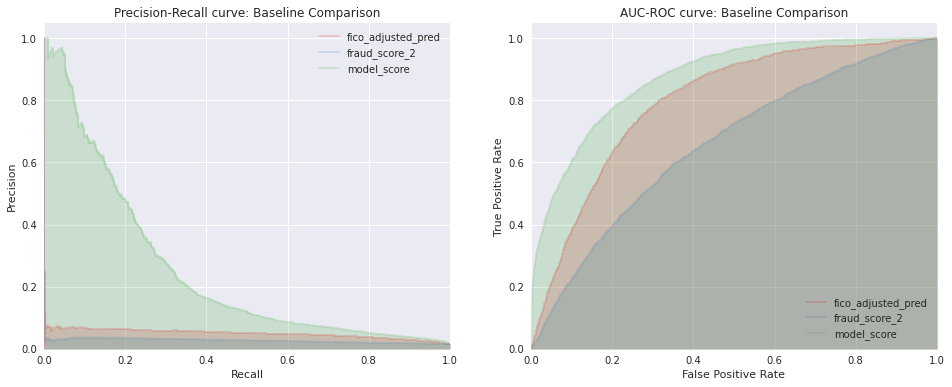

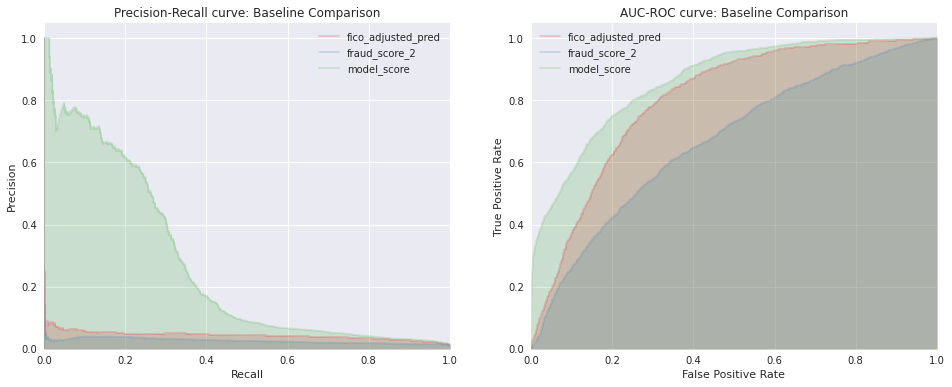

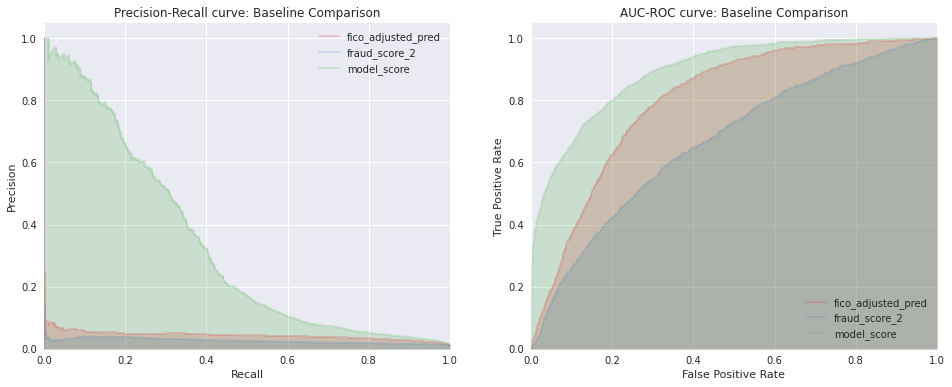

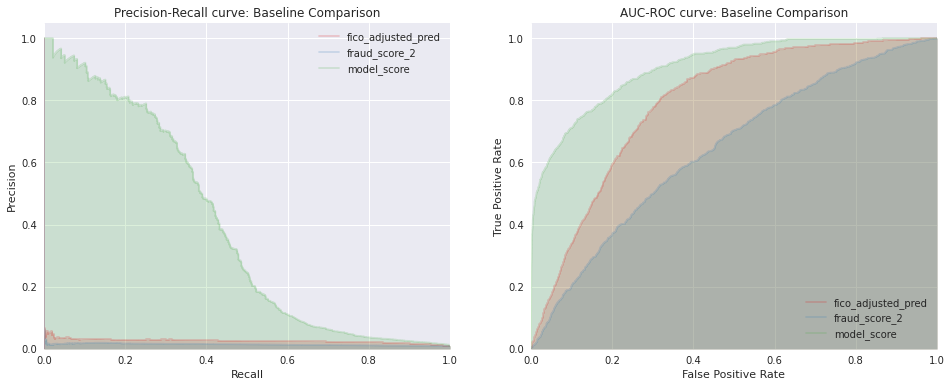

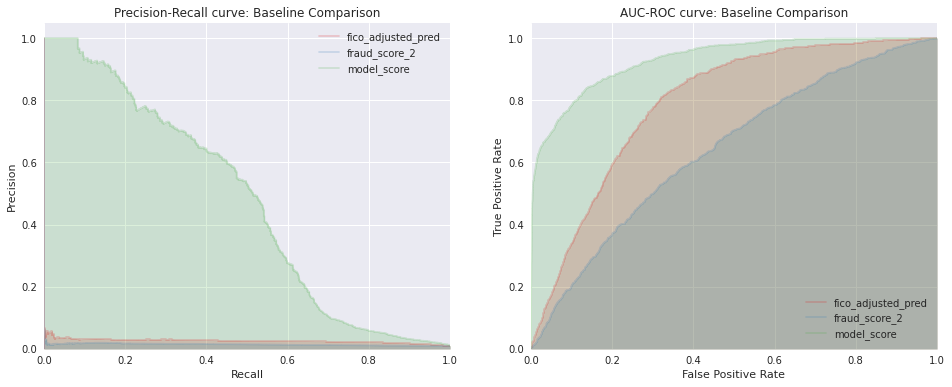

In [16]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_active")
        os.makedirs(mntr_path, exist_ok=True)
        
        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        
        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)  # add is_active flag here
        df_ = df_[df_.is_active]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])


        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma score
        plot_df = df_  # bad style
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )

### Full Population
---

  0%|          | 0/6 [00:00<?, ?it/s]

2021-01-01 (655319, 91)
data imbalance:  130.7239178136844
2021-01-01 (655319, 91)
data imbalance:  130.7239178136844


 17%|█▋        | 1/6 [01:07<05:38, 67.75s/it]

2021-02-01 (729053, 91)
data imbalance:  140.87980676328502
2021-02-01 (729053, 91)
data imbalance:  140.87980676328502


 33%|███▎      | 2/6 [02:23<04:50, 72.52s/it]

2021-03-01 (774235, 91)
data imbalance:  159.37319884726224
2021-03-01 (774235, 91)
data imbalance:  159.37319884726224


 50%|█████     | 3/6 [03:44<03:49, 76.43s/it]

2021-04-01 (828068, 91)
data imbalance:  183.56639326091775
2021-04-01 (828068, 91)
data imbalance:  183.56639326091775


 67%|██████▋   | 4/6 [05:11<02:40, 80.40s/it]

2021-05-01 (869228, 91)
data imbalance:  224.31690322580644
2021-05-01 (869228, 91)
data imbalance:  224.31690322580644


 83%|████████▎ | 5/6 [06:41<01:24, 84.01s/it]

2021-06-01 (906196, 91)
data imbalance:  310.8734133790738
2021-06-01 (906196, 91)
data imbalance:  310.8734133790738


100%|██████████| 6/6 [08:15<00:00, 82.57s/it]


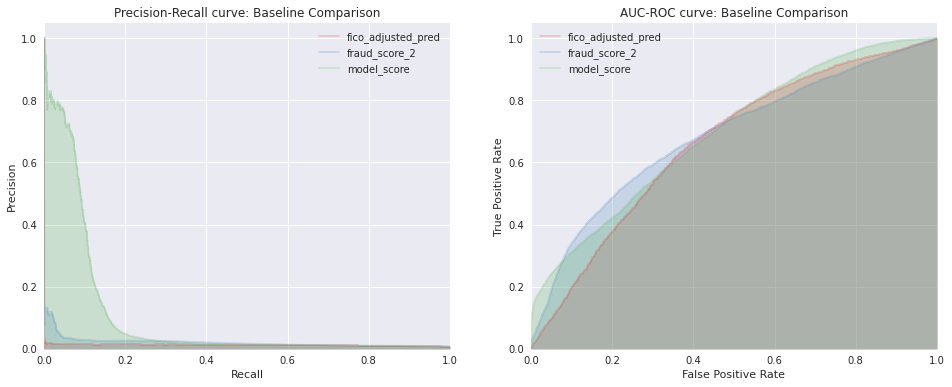

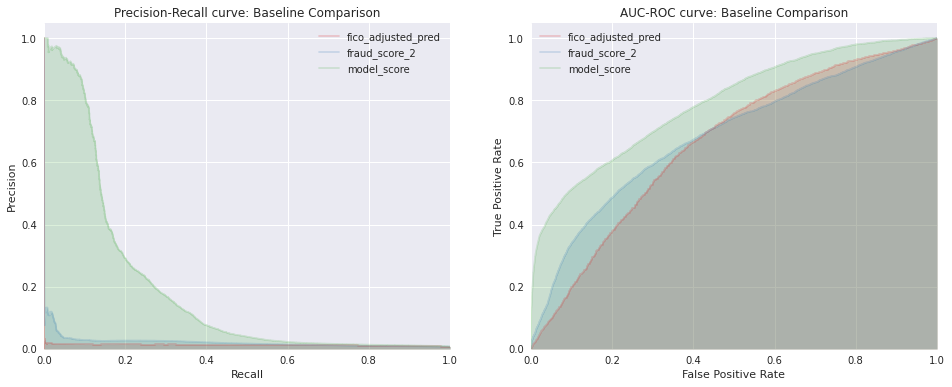

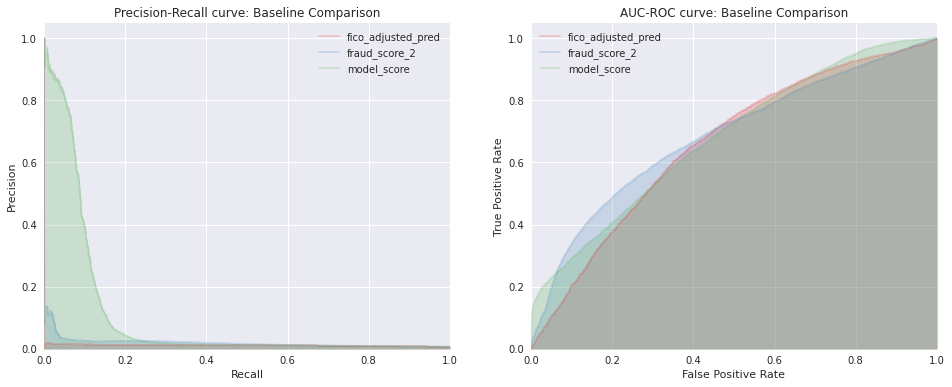

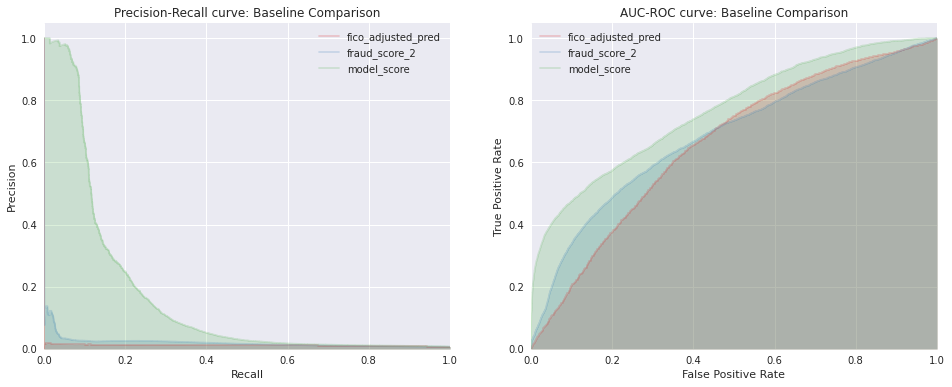

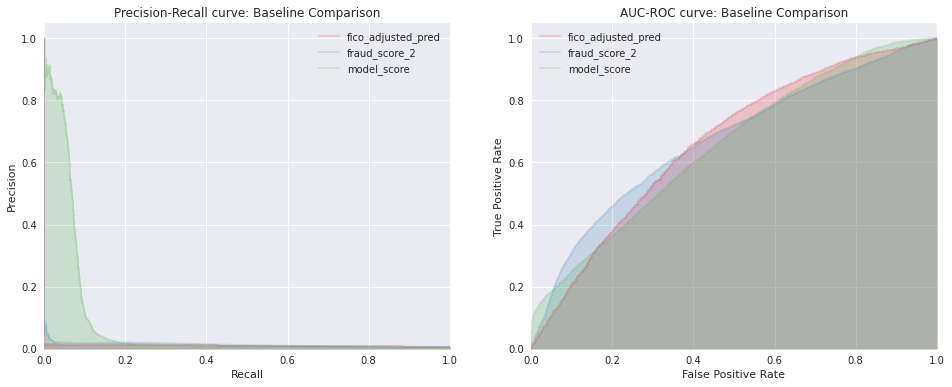

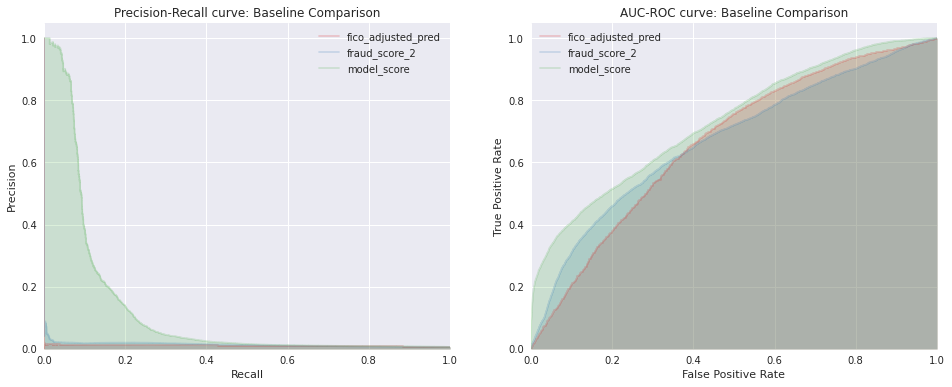

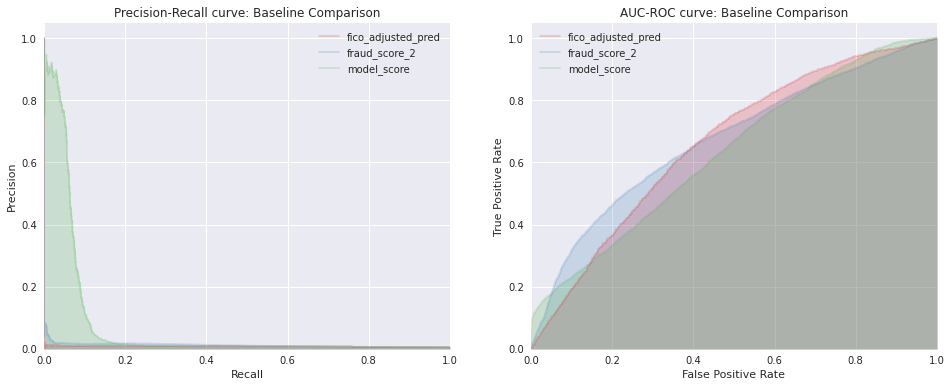

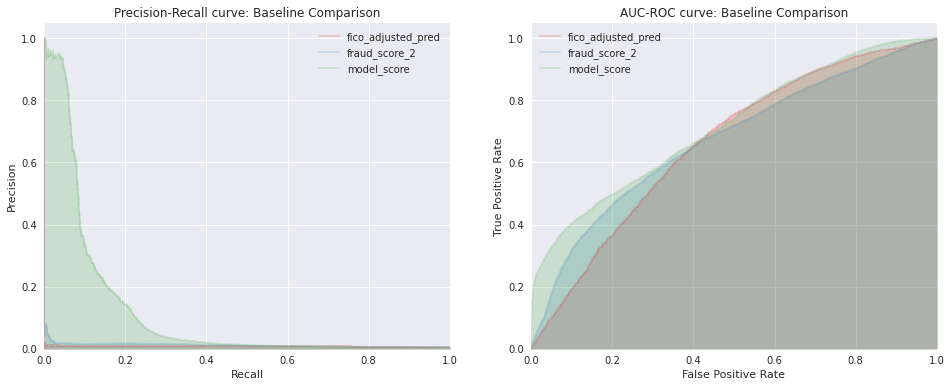

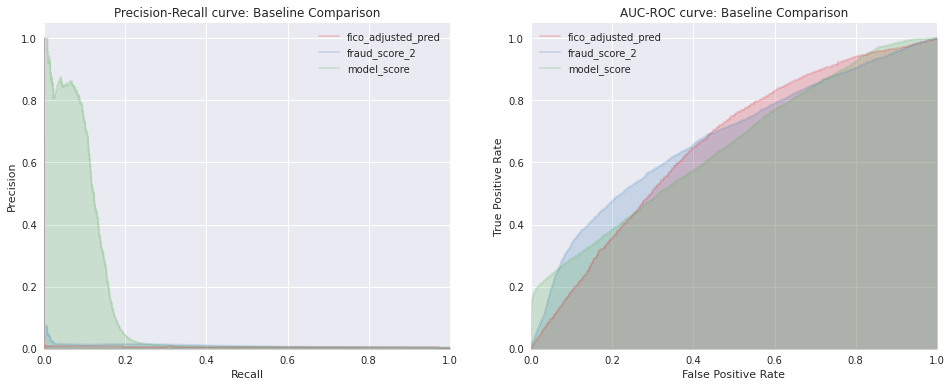

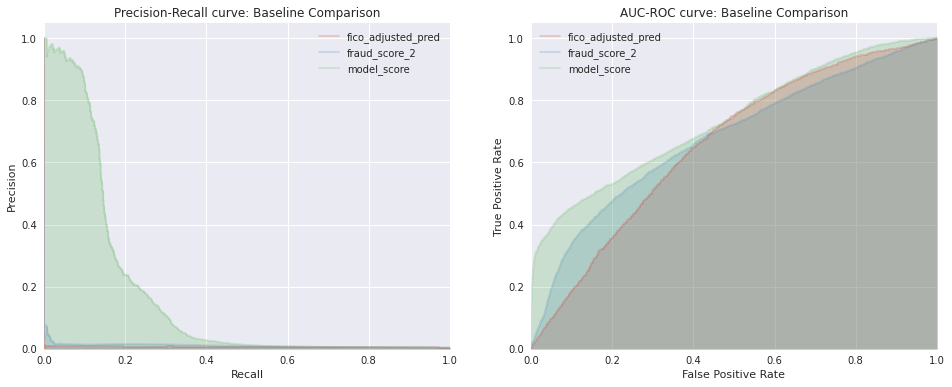

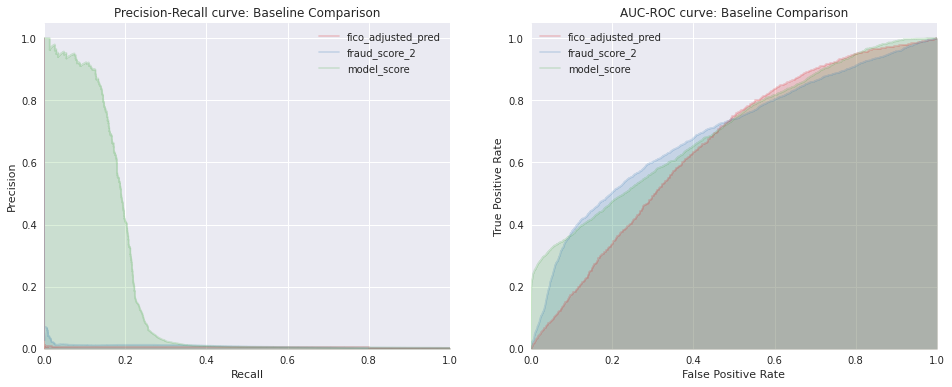

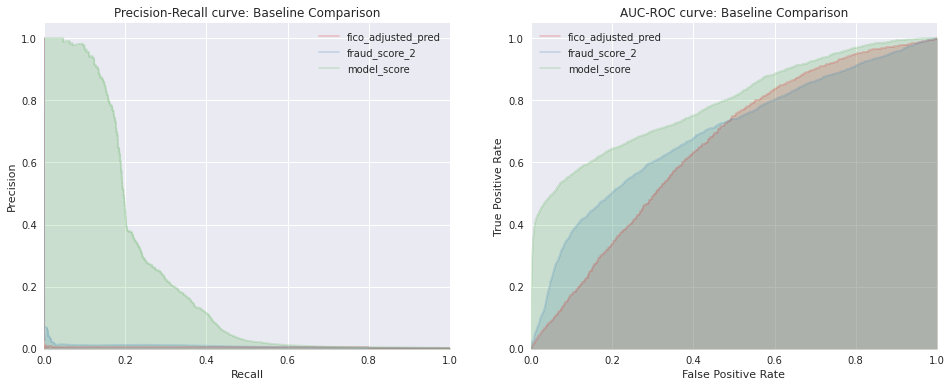

In [17]:
# get all the snapshots
for dt_str in tqdm(monitoring_dates):
    for mname, model in models.items(): 

        dt = pd.to_datetime(dt_str)

        # set folder:
        mntr_path = os.path.join(artifact_path, "monitoring", f"{mname}_{dt_str}_full")        
        os.makedirs(mntr_path, exist_ok=True)

        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        print(dt_str, df_.shape)

        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])

        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)

        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])

        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)

        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))

        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted_pred",
            mntr_path,
        )

        # auc/pr plots - on valid fico and sigma
        plot_df = df_.copy()
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )